In [1]:
!pip install -q kagglehub tensorflow numpy pandas matplotlib scikit-learn opencv-python


In [2]:
import kagglehub

path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
print("Dataset downloaded to:", path)


Using Colab cache for faster access to the 'garbage-classification-v2' dataset.
Dataset downloaded to: /kaggle/input/garbage-classification-v2


In [3]:
import os

print("Contents of main dataset path:")
print(os.listdir(path))

# Auto-detect folder containing image classes
data_dir = None
for root, dirs, files in os.walk(path):
    # A valid dataset folder must contain many class names
    if len(dirs) >= 6:
        common_classes = ["plastic", "paper", "glass", "metal", "cardboard"]
        if any(cls in [d.lower() for d in dirs] for cls in common_classes):
            data_dir = root
            break

print("\nDetected Dataset Folder:", data_dir)
print("Class Folders:", os.listdir(data_dir))


Contents of main dataset path:
['garbage-dataset']

Detected Dataset Folder: /kaggle/input/garbage-classification-v2/garbage-dataset
Class Folders: ['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

labels = list(train_gen.class_indices.keys())
labels


Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.


['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # freeze pretrained layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint("best_mobilenetv2.h5", save_best_only=True, monitor="val_accuracy"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.4804 - loss: 1.6361

495/495 ━━━━━━━━━━━━━━━━━━━━ 455s 906ms/step - accuracy: 0.4807 - loss: 1.6352 - val_accuracy: 0.8010 - val_loss: 0.6205
Epoch 2/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.7657 - loss: 0.7254

495/495 ━━━━━━━━━━━━━━━━━━━━ 391s 791ms/step - accuracy: 0.7657 - loss: 0.7253 - val_accuracy: 0.8319 - val_loss: 0.5181
Epoch 3/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.8076 - loss: 0.5959

495/495 ━━━━━━━━━━━━━━━━━━━━ 392s 791ms/step - accuracy: 0.8076 - loss: 0.5958 - val_accuracy: 0.8438 - val_loss: 0.4692
Epoch 4/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8325 - loss: 0.5350

495/495 ━━━━━━━━━━━━━━━━━━━━ 389s 786ms/step - accuracy: 0.8325 - loss: 0.5349 - val_accuracy: 0.8622 - val_loss: 0.4237
Epoch 5/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8449 - loss: 0.4832

495/495 ━━━━━━━━━━━━━━━━━━━━ 393s 794ms/step - accuracy: 0.8449 - loss: 0.4832 - val_accuracy: 0.8668 - val_loss: 0.4170
Epoch 6/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8517 - loss: 0.4445

495/495 ━━━━━━━━━━━━━━━━━━━━ 385s 778ms/step - accuracy: 0.8517 - loss: 0.4445 - val_accuracy: 0.8671 - val_loss: 0.4083
Epoch 7/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 433s 759ms/step - accuracy: 0.8605 - loss: 0.4342 - val_accuracy: 0.8630 - val_loss: 0.4007
Epoch 8/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8609 - loss: 0.4216

495/495 ━━━━━━━━━━━━━━━━━━━━ 377s 762ms/step - accuracy: 0.8609 - loss: 0.4216 - val_accuracy: 0.8724 - val_loss: 0.3827
Epoch 9/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.8753 - loss: 0.3854

495/495 ━━━━━━━━━━━━━━━━━━━━ 379s 766ms/step - accuracy: 0.8753 - loss: 0.3854 - val_accuracy: 0.8785 - val_loss: 0.3681
Epoch 10/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.8723 - loss: 0.3780

495/495 ━━━━━━━━━━━━━━━━━━━━ 373s 754ms/step - accuracy: 0.8723 - loss: 0.3780 - val_accuracy: 0.8797 - val_loss: 0.3763
Epoch 11/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.8790 - loss: 0.3612

495/495 ━━━━━━━━━━━━━━━━━━━━ 374s 755ms/step - accuracy: 0.8790 - loss: 0.3612 - val_accuracy: 0.8800 - val_loss: 0.3524
Epoch 12/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 364s 736ms/step - accuracy: 0.8845 - loss: 0.3582 - val_accuracy: 0.8762 - val_loss: 0.3652
Epoch 13/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8848 - loss: 0.3422

495/495 ━━━━━━━━━━━━━━━━━━━━ 396s 800ms/step - accuracy: 0.8848 - loss: 0.3422 - val_accuracy: 0.8833 - val_loss: 0.3562
Epoch 14/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8915 - loss: 0.3094

495/495 ━━━━━━━━━━━━━━━━━━━━ 381s 770ms/step - accuracy: 0.8915 - loss: 0.3094 - val_accuracy: 0.8868 - val_loss: 0.3494
Epoch 15/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.8924 - loss: 0.3195

495/495 ━━━━━━━━━━━━━━━━━━━━ 383s 773ms/step - accuracy: 0.8924 - loss: 0.3195 - val_accuracy: 0.8888 - val_loss: 0.3397
Epoch 16/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 391s 790ms/step - accuracy: 0.9029 - loss: 0.2938 - val_accuracy: 0.8863 - val_loss: 0.3318
Epoch 17/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 373s 754ms/step - accuracy: 0.9001 - loss: 0.2967 - val_accuracy: 0.8873 - val_loss: 0.3451
Epoch 18/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.8980 - loss: 0.2943

495/495 ━━━━━━━━━━━━━━━━━━━━ 377s 761ms/step - accuracy: 0.8980 - loss: 0.2943 - val_accuracy: 0.8916 - val_loss: 0.3319
Epoch 19/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 376s 760ms/step - accuracy: 0.9093 - loss: 0.2781 - val_accuracy: 0.8893 - val_loss: 0.3438
Epoch 20/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9079 - loss: 0.2723

495/495 ━━━━━━━━━━━━━━━━━━━━ 376s 759ms/step - accuracy: 0.9079 - loss: 0.2723 - val_accuracy: 0.8939 - val_loss: 0.3319
Epoch 21/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 388s 783ms/step - accuracy: 0.9119 - loss: 0.2713 - val_accuracy: 0.8911 - val_loss: 0.3398


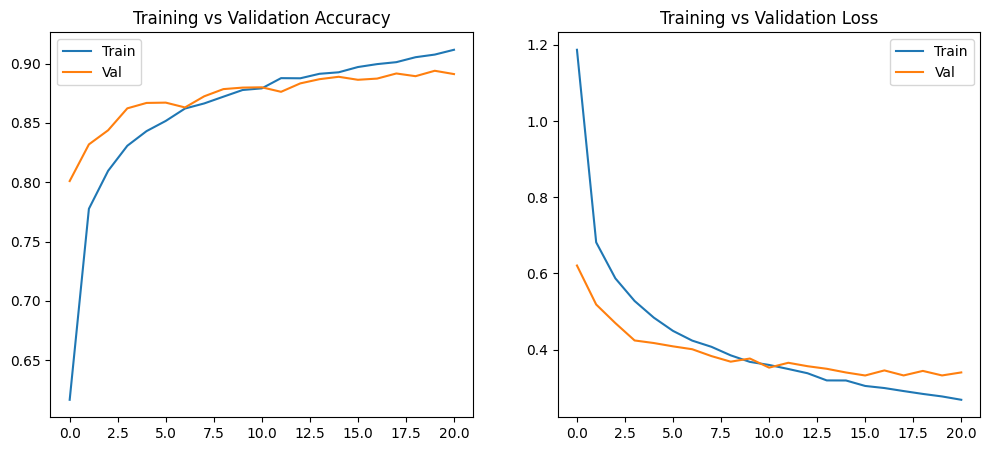

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


124/124 ━━━━━━━━━━━━━━━━━━━━ 76s 609ms/step - accuracy: 0.8806 - loss: 0.3558
Validation Accuracy: 88.40%
124/124 ━━━━━━━━━━━━━━━━━━━━ 79s 615ms/step

Classification Report:
              precision    recall  f1-score   support

     battery       0.06      0.06      0.06       188
  biological       0.03      0.03      0.03       199
   cardboard       0.08      0.08      0.08       365
     clothes       0.25      0.26      0.26      1065
       glass       0.14      0.15      0.14       612
       metal       0.03      0.03      0.03       204
       paper       0.11      0.10      0.10       336
     plastic       0.12      0.11      0.12       396
       shoes       0.09      0.09      0.09       395
       trash       0.05      0.05      0.05       189

    accuracy                           0.14      3949
   macro avg       0.10      0.10      0.10      3949
weighted avg       0.14      0.14      0.14      3949



Saving paper_520.jpg to paper_520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


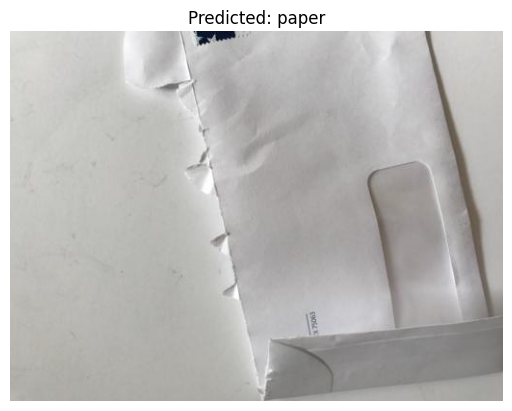

In [14]:
from google.colab import files
uploaded = files.upload()

from tensorflow.keras.preprocessing import image

for file_name in uploaded.keys():
    img = image.load_img(file_name, target_size=(128,128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    predicted_class = labels[np.argmax(pred)]

    plt.imshow(image.load_img(file_name))
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


In [10]:
model.save("mobilenetv2_waste_classification_final.h5")
print("Model saved successfully.")


Model saved successfully.
